In [1]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [2]:
# Experiment setup
experiment_name = '1801'
data_dir = f'./data/{experiment_name}'
exp = decode_eeg.Experiment(experiment_name,data_dir,test=False)

# Decoding with EOG Set size pairs

In [3]:
eog_idx = np.array([ True,  True,  True, False,  True,  True,  True, False,  True,
                    False,  True,  True,  True,  True,  True,  True, False,  True,
                    True,  True,  True,  True,  True, False, False, False, False,
                    True, False, False, False,  True, False])

In [4]:
exp = decode_eeg.Experiment(experiment_name,data_dir,test=False)

exp.eyetracking_files = list(exp.data_dir.glob('*eyetracking*.mat'))
exp.eyetracking_files = list(np.array(exp.eyetracking_files)[eog_idx])
exp.xdata_files = list(np.array(exp.xdata_files)[eog_idx])
exp.ydata_files = list(np.array(exp.ydata_files)[eog_idx])
exp.nsub = len(exp.xdata_files)

# Classification parameters and setup
time_window = 50
time_step = 25
trial_average = 20
n_splits = 1000
group_dict_list =  [{0:[1],1:[2]},{0:[2],1:[3]},{0:[3],1:[4]}]
wrangl = decode_eeg.Wrangler(exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict_list=group_dict_list)

clfr = decode_eeg.Classification(wrangl,exp.nsub,num_labels=2)

In [653]:
# If you want to retrain classifiers, run this cell. Otherwise run next cell.
clfr.acc = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.acc_shuff = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.conf_mat = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits,clfr.num_labels,clfr.num_labels))*np.nan

for isub in range(exp.nsub):
    print(isub)
    
    eye, eye_labels = exp.load_eyetracking(isub)
    eye_idx = np.isin(eye_labels,['HEOG', 'VEOG'])
    xdata_all = eye[:,eye_idx]
    
    ydata_all = exp.load_ydata(isub)
    
    for xdata,ydata in wrangl.pairwise(xdata_all,ydata_all):
        xdata,ydata = wrangl.balance_labels(xdata,ydata)
        xdata,ydata = wrangl.average_trials(xdata,ydata)

        for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
            X_test_all, y_test = wrangl.balance_labels(X_test_all,y_test)
            y_test_shuffle = np.random.permutation(y_test)
            
            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                    clfr.decode_pairwise(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

# Set up interp object and save results.
interp = decode_eeg.Interpreter(clfr,subtitle=f'eog_ss_trialbin{trial_average}_')
interp.save_results()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [6]:
interp = decode_eeg.Interpreter()
interp.load_results('1801_eyetracking_setsize_trialbin20.pickle')

1 vs 2 significant timepoints: []
1 vs 2 mean delay accuracy: 0.5055095238095237
1 vs 2 mean delay S.D.: 0.011703018620905892
2 vs 3 significant timepoints: [784 808]
2 vs 3 mean delay accuracy: 0.5448000000000001
2 vs 3 mean delay S.D.: 0.01602275459981795
3 vs 4 significant timepoints: []
3 vs 4 mean delay accuracy: 0.5074428571428571
3 vs 4 mean delay S.D.: 0.020646343522530575
Saving output\figures\acc_eog_pairwise_.pdf
Saving output\figures\acc_eog_pairwise_.png


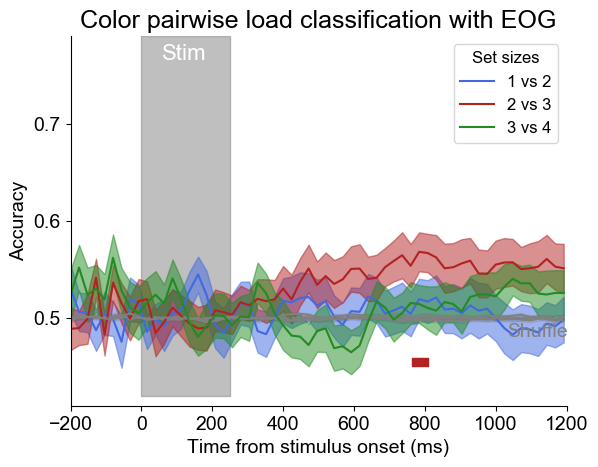

In [8]:
interp.plot_acc_subset(
    subset_list=['1 vs 2','2 vs 3','3 vs 4'],
    ylim=[.41,.79], 
    chance=.5, 
    sig_ys=[.47,.455,.44],
    chance_text_y=.225,
    significance_testing=True,
    title='Color pairwise load classification with EOG',
    subtitle = '_eog_pairwise_',
    legend_title='Set sizes',
    savefig=True)

# Decoding with EEG + EOG, EEG, EOG

In [9]:
exp = decode_eeg.Experiment(experiment_name,data_dir,test=False)
exp.eyetracking_files = list(exp.data_dir.glob('*eyetracking*.mat'))

exp.eyetracking_files = list(np.array(exp.eyetracking_files)[eog_idx])
exp.xdata_files = list(np.array(exp.xdata_files)[eog_idx])
exp.ydata_files = list(np.array(exp.ydata_files)[eog_idx])
exp.nsub = len(exp.xdata_files)

In [10]:
# Classification parameters and setup
time_window = 50
time_step = 25
trial_average = 20
n_splits = 1000
group_dict = {0:[1],1:[2],2:[3],3:[4]}
wrangl = decode_eeg.Wrangler(exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

clfr = decode_eeg.Classification(wrangl,exp.nsub)

In [11]:
clfr.coef = np.empty((exp.nsub,3,wrangl.n_splits,len(wrangl.t)),dtype=object)
clfr.acc = np.zeros((exp.nsub,3,np.size(wrangl.t),wrangl.n_splits))*np.nan
clfr.acc_shuff = np.zeros((exp.nsub,3,np.size(wrangl.t),wrangl.n_splits))*np.nan
clfr.conf_mat = np.zeros((exp.nsub,3,np.size(wrangl.t),wrangl.n_splits,wrangl.num_labels,wrangl.num_labels))*np.nan

In [12]:
idx = [np.arange(32),np.arange(30),np.arange(30,32)]

def roll_subset(xdata,idx):
    for wrangl.ielec, subset_idx in enumerate(idx):
        yield xdata[:,subset_idx]

In [628]:
# If you want to retrain classifiers, run this cell. Otherwise run next cell.
counts = np.empty((exp.nsub,wrangl.n_splits,4))
for isub in range(exp.nsub):
    print(isub)
    
    eye, eye_labels = exp.load_eyetracking(isub)
    eye_idx = np.isin(eye_labels,['HEOG', 'VEOG'])
    eye = eye[:,eye_idx]
    xdata,ydata = exp.load_eeg(isub)
    xdata = np.concatenate([xdata,eye],1)

    xdata_all,ydata_all = wrangl.setup_data(xdata,ydata)

    for xdata in roll_subset(xdata_all,idx):
        for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata_all):
            X_test_all, y_test = wrangl.balance_labels(X_test_all,y_test)
            y_test_shuffle = np.random.permutation(y_test)

            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):

                clfr.decode_electrode_subset(X_train, X_test, y_train, y_test, isub)

# Set up interp object and save results
interp = decode_eeg.Interpreter(clfr, subtitle = f'{experiment_name}_trialbin{str(trial_average)}_eyetracking_')
interp.save_results()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [13]:
interp = decode_eeg.Interpreter()
interp.load_results('1801_eyetracking_trialbin20.pickle')

EEG + EOG significant timepoints: [  88  112  136  160  184  208  232  256  280  304  328  352  376  400
  424  448  472  496  520  544  568  592  616  640  664  688  712  736
  760  784  808  832  856  880  904  928  952  976 1000 1024 1048 1072
 1096 1120 1144 1168 1192]
EEG + EOG mean delay accuracy: 0.4195116071428572
EEG + EOG mean delay S.D.: 0.031228946165997126
EEG significant timepoints: [  88  112  136  160  184  208  232  256  280  304  328  352  376  400
  424  448  472  496  520  544  568  592  616  640  664  688  712  736
  760  784  808  832  856  880  904  928  952  976 1000 1024 1048 1072
 1096 1120 1144 1168 1192]
EEG mean delay accuracy: 0.42071562500000004
EEG mean delay S.D.: 0.027868382624116304
EOG significant timepoints: [ 208  280  328  544  568  592  616  640  664  688  712  736  760  784
  808  832  856  880  904  928  952  976 1000 1024 1048 1072 1096 1120
 1144 1168 1192]
EOG mean delay accuracy: 0.29547068452380953
EOG mean delay S.D.: 0.01768327856342442


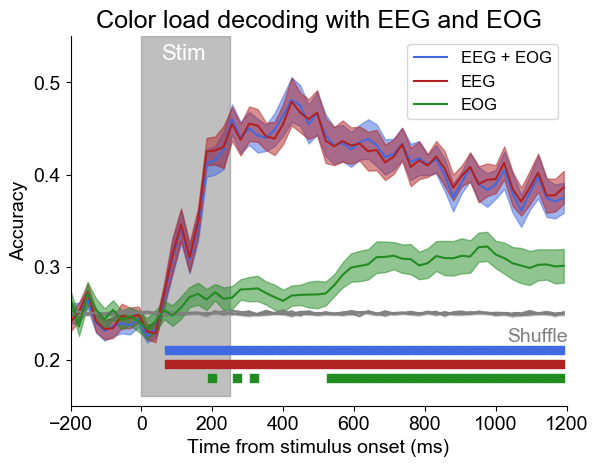

In [15]:
interp.plot_acc_subset(
    subset_list=['EEG + EOG','EEG','EOG'],
    ylim=[.15,.55], 
    chance=.25, 
    sig_ys=[.21,.195, .18], 
    chance_text_y=.211,
    significance_testing=True,
    title='Color load decoding with EEG and EOG',
    subtitle='1801_eeg_and_eog',
    savefig=True)

In [16]:
from copy import copy
conf_mat_copy = interp.conf_mat

Saving output\figures\conf_mat_eeg.pdf
Saving output\figures\conf_mat_eeg.png


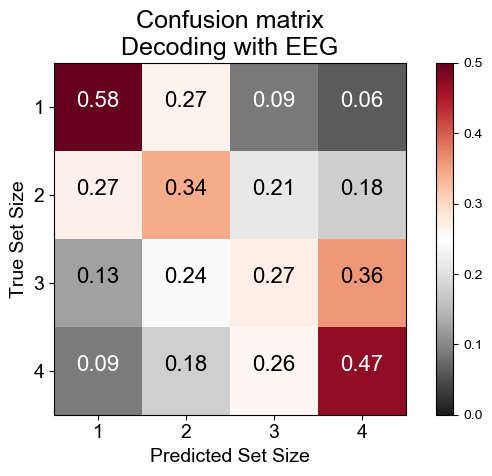

In [28]:
interp.conf_mat = copy(conf_mat_copy)
interp.conf_mat = interp.conf_mat[:,1]
interp.plot_conf_mat(upper=.5,lower=0, savefig=True,subtitle='_eeg',title='Confusion matrix\nDecoding with EEG')

Saving output\figures\conf_mat_eog.pdf
Saving output\figures\conf_mat_eog.png


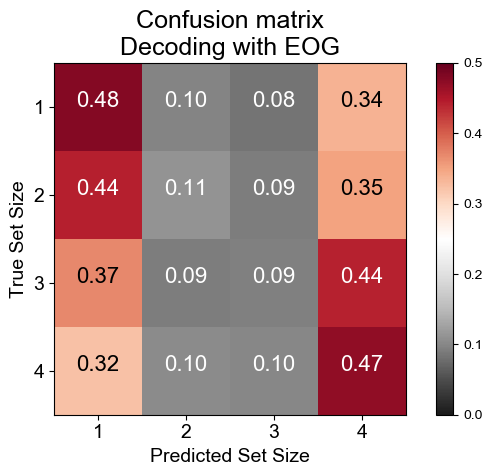

In [29]:
interp.conf_mat = copy(conf_mat_copy)
interp.conf_mat = interp.conf_mat[:,2]
interp.plot_conf_mat(upper=.5,lower=0, savefig=True,subtitle='_eog',title='Confusion matrix\nDecoding with EOG')